### Time Series Forecasting using LSTM

In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from convert_columns_to_floats import *

mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False



In [2]:
## Memory Reducer
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
orig_df = pd.read_csv('/Users/faymajidelhassan/Downloads/Master project /Data/Weather/forecasts/open_meteo.csv') 
df = orig_df.copy() 
print(f'Size of the dataset: {df.shape} \n')  
print() 
display(df.head(5))
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

Size of the dataset: (5292, 16) 




,timestamp,temperature,humidity,pressure_msl,pressure_surface,global_irradiance,direct_irradiance,diffuse_irradiance,cloud_cover,wind_speed,wind_direction,precipitation,rain,showers,snowfall,weather_code
0,2022-07-11 12:00:00,"[22.0, 22.6, 23.1, 23.4, 23.2, 22.7, 21.6, 20....","[42.0, 42.0, 41.0, 39.0, 40.0, 41.0, 49.0, 58....","[1021.5, 1021.0, 1020.6, 1020.2, 1019.7, 1019....","[1007.9, 1007.4, 1007.1, 1006.7, 1006.2, 1006....","[599.0, 645.0, 546.0, 507.0, 393.0, 245.0, 88....","[271.9, 390.3, 333.4, 422.8, 450.5, 389.1, 127...","[352.0, 307.0, 285.0, 226.0, 159.0, 106.0, 64....","[67.0, 80.0, 68.0, 54.0, 57.0, 90.0, 100.0, 10...","[6.2, 6.0, 5.8, 6.2, 6.6, 6.6, 3.2, 1.5, 4.0, ...","[173.0, 147.0, 150.0, 159.0, 158.0, 167.0, 153...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, ..."
1,2022-07-11 13:00:00,"[22.6, 23.1, 23.4, 23.2, 22.7, 21.6, 20.3, 18....","[42.0, 41.0, 39.0, 40.0, 41.0, 49.0, 58.0, 64....","[1021.0, 1020.6, 1020.2, 1019.7, 1019.8, 1020....","[1007.4, 1007.1, 1006.7, 1006.2, 1006.2, 1006....","[645.0, 546.0, 507.0, 393.0, 245.0, 88.0, 10.0...","[390.3, 333.4, 422.8, 450.5, 389.1, 127.0, 0.0...","[307.0, 285.0, 226.0, 159.0, 106.0, 64.0, 10.0...","[80.0, 68.0, 54.0, 57.0, 90.0, 100.0, 100.0, 1...","[6.0, 5.8, 6.2, 6.6, 6.6, 3.2, 1.5, 4.0, 2.9, ...","[147.0, 150.0, 159.0, 158.0, 167.0, 153.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
2,2022-07-11 14:00:00,"[23.2, 23.6, 23.5, 23.0, 22.1, 20.4, 18.9, 18....","[38.0, 38.0, 38.0, 39.0, 46.0, 54.0, 63.0, 62....","[1020.6, 1020.3, 1019.6, 1019.6, 1020.0, 1020....","[1007.1, 1006.8, 1006.1, 1006.1, 1006.4, 1006....","[417.0, 442.0, 417.0, 267.0, 96.0, 11.0, 0.0, ...","[149.5, 287.4, 525.5, 481.5, 158.8, 0.0, 0.0, ...","[300.0, 251.0, 144.0, 95.0, 66.0, 11.0, 0.0, 0...","[86.0, 62.0, 24.0, 88.0, 100.0, 100.0, 100.0, ...","[4.0, 5.6, 6.8, 5.3, 4.5, 2.5, 2.9, 3.7, 1.3, ...","[170.0, 165.0, 155.0, 152.0, 166.0, 90.0, 7.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
3,2022-07-11 15:00:00,"[23.6, 23.5, 23.0, 22.1, 20.4, 18.9, 18.2, 18....","[38.0, 38.0, 39.0, 46.0, 54.0, 63.0, 62.0, 65....","[1020.3, 1019.6, 1019.6, 1020.0, 1020.5, 1021....","[1006.8, 1006.1, 1006.1, 1006.4, 1006.8, 1007....","[442.0, 417.0, 267.0, 96.0, 11.0, 0.0, 0.0, 0....","[287.4, 525.5, 481.5, 158.8, 0.0, 0.0, 0.0, 0....","[251.0, 144.0, 95.0, 66.0, 11.0, 0.0, 0.0, 0.0...","[62.0, 24.0, 88.0, 100.0, 100.0, 100.0, 92.0, ...","[5.6, 6.8, 5.3, 4.5, 2.5, 2.9, 3.7, 1.3, 2.1, ...","[165.0, 155.0, 152.0, 166.0, 90.0, 7.0, 11.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, ..."
4,2022-07-11 16:00:00,"[23.5, 23.0, 22.1, 20.4, 18.9, 18.2, 18.0, 17....","[38.0, 39.0, 46.0, 54.0, 63.0, 62.0, 65.0, 65....","[1019.6, 1019.6, 1020.0, 1020.5, 1021.1, 1021....","[1006.1, 1006.1, 1006.4, 1006.8, 1007.4, 1007....","[417.0, 267.0, 96.0, 11.0, 0.0, 0.0, 0.0, 0.0,...","[525.5, 481.5, 158.8, 0.0, 0.0, 0.0, 0.0, 0.0,...","[144.0, 95.0, 66.0, 11.0, 0.0, 0.0, 0.0, 0.0, ...","[24.0, 88.0, 100.0, 100.0, 100.0, 92.0, 90.0, ...","[6.8, 5.3, 4.5, 2.5, 2.9, 3.7, 1.3, 2.1, 3.1, ...","[155.0, 152.0, 166.0, 90.0, 7.0, 11.0, 146.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [4]:
features=[
    'temperature', 'humidity', 'pressure_msl', 'pressure_surface', 
    'global_irradiance', 'direct_irradiance', 'diffuse_irradiance', 
    'cloud_cover', 'wind_speed', 'wind_direction', 'precipitation', 
    'rain', 'showers', 'snowfall']
def convert_columns_to_floats2(df, columns_to_convert):
    for col in columns_to_convert:
        print(f"Processing column: {col}")
        df[col] = df[col].astype(str).apply(parse_complex_string)
        print(f"Processed column: {col}")
    return df
def reduce_cells_for_all_columns(df, columns_to_reduce,n=int):
    '''
    Reduce each cell in each column by 96 values from the end
    '''
    for col in columns_to_reduce:
        df[col] = df[col].apply(lambda x: x[:n] if len(x) > n else x + [None] * (n - len(x)))
    return df
def get_lengths_of_cells(df, columns):
    '''
    Get the lengths of cells in each specified column
    '''
    lengths = {col: df[col].apply(lambda x: len(x) if isinstance(x, list) else np.nan) for col in columns}
    return pd.DataFrame(lengths)
# df = convert_columns_to_numeric_lists(df, columns_to_convert2)
df= convert_columns_to_floats2(df, features)
lengths_df = get_lengths_of_cells(df, features)
df= reduce_cells_for_all_columns(df, features, 96)
# print("Lengths of cells before reduction:")
print(lengths_df)
df

Processing column: temperature
Processed column: temperature
Processing column: humidity
Processed column: humidity
Processing column: pressure_msl
Processed column: pressure_msl
Processing column: pressure_surface
Processed column: pressure_surface
Processing column: global_irradiance
Processed column: global_irradiance
Processing column: direct_irradiance
Processed column: direct_irradiance
Processing column: diffuse_irradiance
Processed column: diffuse_irradiance
Processing column: cloud_cover
Processed column: cloud_cover
Processing column: wind_speed
Processed column: wind_speed
Processing column: wind_direction
Processed column: wind_direction
Processing column: precipitation
Processed column: precipitation
Processing column: rain
Processed column: rain
Processing column: showers
Processed column: showers
Processing column: snowfall
Processed column: snowfall
                     temperature  humidity  pressure_msl  pressure_surface  \
timestamp                                   

,temperature,humidity,pressure_msl,pressure_surface,global_irradiance,direct_irradiance,diffuse_irradiance,cloud_cover,wind_speed,wind_direction,precipitation,rain,showers,snowfall,weather_code
timestamp,,,,,,,,,,,,,,,
2022-07-11 12:00:00,"[22.0, 22.6, 23.1, 23.4, 23.2, 22.7, 21.6, 20....","[42.0, 42.0, 41.0, 39.0, 40.0, 41.0, 49.0, 58....","[1021.5, 1021.0, 1020.6, 1020.2, 1019.7, 1019....","[1007.9, 1007.4, 1007.1, 1006.7, 1006.2, 1006....","[599.0, 645.0, 546.0, 507.0, 393.0, 245.0, 88....","[271.9, 390.3, 333.4, 422.8, 450.5, 389.1, 127...","[352.0, 307.0, 285.0, 226.0, 159.0, 106.0, 64....","[67.0, 80.0, 68.0, 54.0, 57.0, 90.0, 100.0, 10...","[6.2, 6.0, 5.8, 6.2, 6.6, 6.6, 3.2, 1.5, 4.0, ...","[173.0, 147.0, 150.0, 159.0, 158.0, 167.0, 153...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, ..."
2022-07-11 13:00:00,"[22.6, 23.1, 23.4, 23.2, 22.7, 21.6, 20.3, 18....","[42.0, 41.0, 39.0, 40.0, 41.0, 49.0, 58.0, 64....","[1021.0, 1020.6, 1020.2, 1019.7, 1019.8, 1020....","[1007.4, 1007.1, 1006.7, 1006.2, 1006.2, 1006....","[645.0, 546.0, 507.0, 393.0, 245.0, 88.0, 10.0...","[390.3, 333.4, 422.8, 450.5, 389.1, 127.0, 0.0...","[307.0, 285.0, 226.0, 159.0, 106.0, 64.0, 10.0...","[80.0, 68.0, 54.0, 57.0, 90.0, 100.0, 100.0, 1...","[6.0, 5.8, 6.2, 6.6, 6.6, 3.2, 1.5, 4.0, 2.9, ...","[147.0, 150.0, 159.0, 158.0, 167.0, 153.0, 104...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
2022-07-11 14:00:00,"[23.2, 23.6, 23.5, 23.0, 22.1, 20.4, 18.9, 18....","[38.0, 38.0, 38.0, 39.0, 46.0, 54.0, 63.0, 62....","[1020.6, 1020.3, 1019.6, 1019.6, 1020.0, 1020....","[1007.1, 1006.8, 1006.1, 1006.1, 1006.4, 1006....","[417.0, 442.0, 417.0, 267.0, 96.0, 11.0, 0.0, ...","[149.5, 287.4, 525.5, 481.5, 158.8, 0.0, 0.0, ...","[300.0, 251.0, 144.0, 95.0, 66.0, 11.0, 0.0, 0...","[86.0, 62.0, 24.0, 88.0, 100.0, 100.0, 100.0, ...","[4.0, 5.6, 6.8, 5.3, 4.5, 2.5, 2.9, 3.7, 1.3, ...","[170.0, 165.0, 155.0, 152.0, 166.0, 90.0, 7.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.0, 2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, ..."
2022-07-11 15:00:00,"[23.6, 23.5, 23.0, 22.1, 20.4, 18.9, 18.2, 18....","[38.0, 38.0, 39.0, 46.0, 54.0, 63.0, 62.0, 65....","[1020.3, 1019.6, 1019.6, 1020.0, 1020.5, 1021....","[1006.8, 1006.1, 1006.1, 1006.4, 1006.8, 1007....","[442.0, 417.0, 267.0, 96.0, 11.0, 0.0, 0.0, 0....","[287.4, 525.5, 481.5, 158.8, 0.0, 0.0, 0.0, 0....","[251.0, 144.0, 95.0, 66.0, 11.0, 0.0, 0.0, 0.0...","[62.0, 24.0, 88.0, 100.0, 100.0, 100.0, 92.0, ...","[5.6, 6.8, 5.3, 4.5, 2.5, 2.9, 3.7, 1.3, 2.1, ...","[165.0, 155.0, 152.0, 166.0, 90.0, 7.0, 11.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 1.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, ..."
2022-07-11 16:00:00,"[23.5, 23.0, 22.1, 20.4, 18.9, 18.2, 18.0, 17....","[38.0, 39.0, 46.0, 54.0, 63.0, 62.0, 65.0, 65....","[1019.6, 1019.6, 1020.0, 1020.5, 1021.1, 1021....","[1006.1, 1006.1, 1006.4, 1006.8, 1007.4, 1007....","[417.0, 267.0, 96.0, 11.0, 0.0, 0.0, 0.0, 0.0,...","[525.5, 481.5, 158.8, 0.0, 0.0, 0.0, 0.0, 0.0,...","[144.0, 95.0, 66.0, 11.0, 0.0, 0.0, 0.0, 0.0, ...","[24.0, 88.0, 100.0, 100.0, 100.0, 92.0, 90.0, ...","[6.8, 5.3, 4.5, 2.5, 2.9, 3.7, 1.3, 2.1, 3.1, ...","[155.0, 152.0, 166.0, 90.0, 7.0, 11.0, 146.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [5]:
# import json 
# def safe_json_loads(x):
#     if isinstance(x, str):
#         try:
#             return np.array(json.loads(x))
#         except (json.JSONDecodeError, TypeError) as e:
#             print(f"Error parsing JSON for value: {x}, error: {e}")
#             return np.nan  # Or handle differently as needed
#     elif isinstance(x, np.ndarray):
#         return x
#     else:
#         return np.nan

# # Apply JSON parsing to the DataFrame columns
# for for_val in [
#     'temperature', 'humidity', 'pressure_msl', 'pressure_surface', 
#     'global_irradiance', 'direct_irradiance', 'diffuse_irradiance', 
#     'cloud_cover', 'wind_speed', 'wind_direction', 'precipitation', 
#     'rain', 'showers', 'snowfall', 'weather_code'
# ]:
#     df[for_val] = df[for_val].map(safe_json_loads)

# # Inspect the DataFrame to ensure proper parsing
# df

In [6]:
# # switch forecasts sequences from string to np array
# import json
# for for_val in [
#     'temperature', 'humidity', 'pressure_msl', 'pressure_surface', 
#     'global_irradiance', 'direct_irradiance', 'diffuse_irradiance', 
#     'cloud_cover', 'wind_speed', 'wind_direction', 'precipitation', 
#     'rain', 'showers', 'snowfall', 'weather_code'
# ]:
#         df[for_val] = df[for_val].map(lambda x: np.array(json.loads(x)), na_action='ignore')
# df

In [7]:
# pick one meteo variable
meas = 'temperature'
df_for = df.loc[:,[meas]]
df_for

,temperature
timestamp,
2022-07-11 12:00:00,"[22.0, 22.6, 23.1, 23.4, 23.2, 22.7, 21.6, 20...."
2022-07-11 13:00:00,"[22.6, 23.1, 23.4, 23.2, 22.7, 21.6, 20.3, 18...."
2022-07-11 14:00:00,"[23.2, 23.6, 23.5, 23.0, 22.1, 20.4, 18.9, 18...."
2022-07-11 15:00:00,"[23.6, 23.5, 23.0, 22.1, 20.4, 18.9, 18.2, 18...."
2022-07-11 16:00:00,"[23.5, 23.0, 22.1, 20.4, 18.9, 18.2, 18.0, 17...."
...,...
2023-02-17 08:00:00,"[4.0, 7.3, 10.3, 12.4, 13.9, 14.9, 15.9, 15.6,..."
2023-02-17 09:00:00,"[7.3, 10.3, 12.4, 13.9, 14.9, 15.9, 15.6, 13.6..."
2023-02-17 10:00:00,"[10.3, 12.4, 13.9, 14.9, 15.9, 15.6, 13.6, 10...."


In [8]:
# pick one meteo variable
measP = 'precipitation'
df_forP = df.loc[:,[measP]]
df_forP

,precipitation
timestamp,
2022-07-11 12:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2022-07-11 13:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2022-07-11 14:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2022-07-11 15:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2022-07-11 16:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...
2023-02-17 08:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2023-02-17 09:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2023-02-17 10:00:00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [9]:
measH = 'humidity'
df_forH = df.loc[:,[measH]]
df_forH

,humidity
timestamp,
2022-07-11 12:00:00,"[42.0, 42.0, 41.0, 39.0, 40.0, 41.0, 49.0, 58...."
2022-07-11 13:00:00,"[42.0, 41.0, 39.0, 40.0, 41.0, 49.0, 58.0, 64...."
2022-07-11 14:00:00,"[38.0, 38.0, 38.0, 39.0, 46.0, 54.0, 63.0, 62...."
2022-07-11 15:00:00,"[38.0, 38.0, 39.0, 46.0, 54.0, 63.0, 62.0, 65...."
2022-07-11 16:00:00,"[38.0, 39.0, 46.0, 54.0, 63.0, 62.0, 65.0, 65...."
...,...
2023-02-17 08:00:00,"[90.0, 75.0, 64.0, 58.0, 50.0, 48.0, 47.0, 48...."
2023-02-17 09:00:00,"[75.0, 64.0, 58.0, 50.0, 48.0, 47.0, 48.0, 54...."
2023-02-17 10:00:00,"[64.0, 58.0, 50.0, 48.0, 47.0, 48.0, 54.0, 67...."


In [10]:
measGr = 'global_irradiance'
df_forGr = df.loc[:,[measGr]]
df_forGr

,global_irradiance
timestamp,
2022-07-11 12:00:00,"[599.0, 645.0, 546.0, 507.0, 393.0, 245.0, 88...."
2022-07-11 13:00:00,"[645.0, 546.0, 507.0, 393.0, 245.0, 88.0, 10.0..."
2022-07-11 14:00:00,"[417.0, 442.0, 417.0, 267.0, 96.0, 11.0, 0.0, ..."
2022-07-11 15:00:00,"[442.0, 417.0, 267.0, 96.0, 11.0, 0.0, 0.0, 0...."
2022-07-11 16:00:00,"[417.0, 267.0, 96.0, 11.0, 0.0, 0.0, 0.0, 0.0,..."
...,...
2023-02-17 08:00:00,"[170.0, 309.0, 415.0, 468.0, 491.0, 438.0, 337..."
2023-02-17 09:00:00,"[309.0, 415.0, 468.0, 491.0, 438.0, 337.0, 220..."
2023-02-17 10:00:00,"[415.0, 468.0, 491.0, 438.0, 337.0, 220.0, 79...."


In [11]:
#unpack forecasts
df_for.dropna(how='any',inplace=True)
df_for_cols_ext = [meas+'_forecast+'+str(i)+'h' for i in range(0,len(df_for[meas].values[0]))]
df_for = pd.DataFrame(index=df_for.index, data=df_for[meas].to_list(), columns=df_for_cols_ext)

# df_for = df_for.asfreq('6H')
# df_for

In [12]:
#unpack forecasts
df_forP.dropna(how='any',inplace=True)
df_for_cols_ext = [measP+'_forecast+'+str(i)+'h' for i in range(0,len(df_forP[measP].values[0]))]
df_forP = pd.DataFrame(index=df_forP.index, data=df_forP[measP].to_list(), columns=df_for_cols_ext)
# df_forP = df_forP.asfreq('6H')
# df_forP

In [13]:
df_forH.dropna(how='any',inplace=True)
df_for_cols_ext = [measH+'_forecast+'+str(i)+'h' for i in range(0,len(df_forH[measH].values[0]))]
df_forH = pd.DataFrame(index=df_forH.index, data=df_forH[measH].to_list(), columns=df_for_cols_ext)

In [14]:
df_forGr.dropna(how='any',inplace=True)
df_for_cols_ext = [measGr+'_forecast+'+str(i)+'h' for i in range(0,len(df_forGr[measGr].values[0]))]
df_forGr = pd.DataFrame(index=df_forGr.index, data=df_forGr[measGr].to_list(), columns=df_for_cols_ext)

In [15]:
# df_for.isnull().sum()
# df_forP.isnull().sum()
# df_forH.isnull().sum()
# df_forGr.isnull().sum()

In [16]:
dfT=df_for.fillna(method='ffill')
dfP = df_forP.fillna(method='ffill')
dfH=df_forH.fillna(method='ffill')
dfGr=df_forGr.fillna(method='ffill')


In [17]:
# reduce memory usage
dfT= reduce_mem_usage(dfT)
dfP= reduce_mem_usage(dfP)
dfH= reduce_mem_usage(dfH)
dfGr= reduce_mem_usage(dfGr)

Mem. usage decreased to  1.01 Mb (74.2% reduction)
Mem. usage decreased to  1.01 Mb (74.2% reduction)
Mem. usage decreased to  1.01 Mb (74.2% reduction)
Mem. usage decreased to  1.01 Mb (74.2% reduction)


In [18]:
dfT

,temperature_forecast+0h,temperature_forecast+1h,temperature_forecast+2h,temperature_forecast+3h,temperature_forecast+4h,temperature_forecast+5h,temperature_forecast+6h,temperature_forecast+7h,temperature_forecast+8h,temperature_forecast+9h,...,temperature_forecast+86h,temperature_forecast+87h,temperature_forecast+88h,temperature_forecast+89h,temperature_forecast+90h,temperature_forecast+91h,temperature_forecast+92h,temperature_forecast+93h,temperature_forecast+94h,temperature_forecast+95h
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-11 12:00:00,22.000000,22.593750,23.093750,23.406250,23.203125,22.703125,21.593750,20.296875,18.593750,17.406250,...,20.296875,20.203125,21.093750,22.593750,24.406250,25.296875,26.093750,27.000000,28.000000,29.000000
2022-07-11 13:00:00,22.593750,23.093750,23.406250,23.203125,22.703125,21.593750,20.296875,18.593750,17.406250,17.296875,...,20.203125,21.093750,22.593750,24.406250,25.296875,26.093750,27.000000,28.000000,29.000000,30.093750
2022-07-11 14:00:00,23.203125,23.593750,23.500000,23.000000,22.093750,20.406250,18.906250,18.203125,18.000000,17.593750,...,21.093750,22.593750,24.406250,25.296875,26.093750,27.000000,28.000000,29.000000,30.093750,30.406250
2022-07-11 15:00:00,23.593750,23.500000,23.000000,22.093750,20.406250,18.906250,18.203125,18.000000,17.593750,16.906250,...,22.593750,24.406250,25.296875,26.093750,27.000000,28.000000,29.000000,30.093750,30.406250,30.406250
2022-07-11 16:00:00,23.500000,23.000000,22.093750,20.406250,18.906250,18.203125,18.000000,17.593750,16.906250,16.500000,...,23.500000,24.500000,25.406250,26.500000,27.296875,28.000000,28.703125,29.093750,29.296875,29.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,4.000000,7.300781,10.296875,12.398438,13.898438,14.898438,15.898438,15.601562,13.601562,10.601562,...,10.601562,10.500000,10.398438,10.296875,10.296875,10.000000,9.398438,8.703125,8.500000,9.601562
2023-02-17 09:00:00,7.300781,10.296875,12.398438,13.898438,14.898438,15.898438,15.601562,13.601562,10.601562,8.500000,...,10.500000,10.398438,10.296875,10.296875,10.000000,9.398438,8.703125,8.500000,9.601562,11.398438
2023-02-17 10:00:00,10.296875,12.398438,13.898438,14.898438,15.898438,15.601562,13.601562,10.601562,8.500000,7.500000,...,8.796875,8.703125,8.703125,8.601562,8.398438,8.000000,8.296875,9.398438,11.101562,13.296875


In [19]:
dfP

,precipitation_forecast+0h,precipitation_forecast+1h,precipitation_forecast+2h,precipitation_forecast+3h,precipitation_forecast+4h,precipitation_forecast+5h,precipitation_forecast+6h,precipitation_forecast+7h,precipitation_forecast+8h,precipitation_forecast+9h,...,precipitation_forecast+86h,precipitation_forecast+87h,precipitation_forecast+88h,precipitation_forecast+89h,precipitation_forecast+90h,precipitation_forecast+91h,precipitation_forecast+92h,precipitation_forecast+93h,precipitation_forecast+94h,precipitation_forecast+95h
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-11 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-11 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-11 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-11 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-07-11 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-17 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023-02-17 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
dfH

,humidity_forecast+0h,humidity_forecast+1h,humidity_forecast+2h,humidity_forecast+3h,humidity_forecast+4h,humidity_forecast+5h,humidity_forecast+6h,humidity_forecast+7h,humidity_forecast+8h,humidity_forecast+9h,...,humidity_forecast+86h,humidity_forecast+87h,humidity_forecast+88h,humidity_forecast+89h,humidity_forecast+90h,humidity_forecast+91h,humidity_forecast+92h,humidity_forecast+93h,humidity_forecast+94h,humidity_forecast+95h
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-11 12:00:00,42.0,42.0,41.0,39.0,40.0,41.0,49.0,58.0,64.0,67.0,...,61.0,61.0,59.0,56.0,54.0,53.0,53.0,52.0,50.0,47.0
2022-07-11 13:00:00,42.0,41.0,39.0,40.0,41.0,49.0,58.0,64.0,67.0,66.0,...,61.0,59.0,56.0,54.0,53.0,53.0,52.0,50.0,47.0,44.0
2022-07-11 14:00:00,38.0,38.0,38.0,39.0,46.0,54.0,63.0,62.0,65.0,65.0,...,59.0,56.0,54.0,53.0,53.0,52.0,50.0,47.0,44.0,43.0
2022-07-11 15:00:00,38.0,38.0,39.0,46.0,54.0,63.0,62.0,65.0,65.0,67.0,...,56.0,54.0,53.0,53.0,52.0,50.0,47.0,44.0,43.0,42.0
2022-07-11 16:00:00,38.0,39.0,46.0,54.0,63.0,62.0,65.0,65.0,67.0,65.0,...,59.0,55.0,51.0,46.0,42.0,39.0,35.0,34.0,34.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,90.0,75.0,64.0,58.0,50.0,48.0,47.0,48.0,54.0,67.0,...,67.0,67.0,66.0,65.0,64.0,64.0,66.0,69.0,71.0,69.0
2023-02-17 09:00:00,75.0,64.0,58.0,50.0,48.0,47.0,48.0,54.0,67.0,79.0,...,67.0,66.0,65.0,64.0,64.0,66.0,69.0,71.0,69.0,64.0
2023-02-17 10:00:00,64.0,58.0,50.0,48.0,47.0,48.0,54.0,67.0,79.0,81.0,...,69.0,69.0,70.0,71.0,73.0,75.0,75.0,72.0,66.0,59.0


In [21]:
dfGr

,global_irradiance_forecast+0h,global_irradiance_forecast+1h,global_irradiance_forecast+2h,global_irradiance_forecast+3h,global_irradiance_forecast+4h,global_irradiance_forecast+5h,global_irradiance_forecast+6h,global_irradiance_forecast+7h,global_irradiance_forecast+8h,global_irradiance_forecast+9h,...,global_irradiance_forecast+86h,global_irradiance_forecast+87h,global_irradiance_forecast+88h,global_irradiance_forecast+89h,global_irradiance_forecast+90h,global_irradiance_forecast+91h,global_irradiance_forecast+92h,global_irradiance_forecast+93h,global_irradiance_forecast+94h,global_irradiance_forecast+95h
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-07-11 12:00:00,599.0,645.0,546.0,507.0,393.0,245.0,88.0,10.0,0.0,0.0,...,0.0,0.0,10.0,105.0,209.0,332.0,475.0,630.0,741.0,818.0
2022-07-11 13:00:00,645.0,546.0,507.0,393.0,245.0,88.0,10.0,0.0,0.0,0.0,...,0.0,10.0,105.0,209.0,332.0,475.0,630.0,741.0,818.0,846.0
2022-07-11 14:00:00,417.0,442.0,417.0,267.0,96.0,11.0,0.0,0.0,0.0,0.0,...,10.0,105.0,209.0,332.0,475.0,630.0,741.0,818.0,846.0,804.0
2022-07-11 15:00:00,442.0,417.0,267.0,96.0,11.0,0.0,0.0,0.0,0.0,0.0,...,105.0,209.0,332.0,475.0,630.0,741.0,818.0,846.0,804.0,710.0
2022-07-11 16:00:00,417.0,267.0,96.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,...,183.0,304.0,457.0,627.0,733.0,794.0,812.0,785.0,713.0,581.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-17 08:00:00,170.0,309.0,415.0,468.0,491.0,438.0,337.0,220.0,79.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
2023-02-17 09:00:00,309.0,415.0,468.0,491.0,438.0,337.0,220.0,79.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,125.0
2023-02-17 10:00:00,415.0,468.0,491.0,438.0,337.0,220.0,79.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,123.0,305.0


Observations:
1) One reading evrry 10 mins (from datatime column time diff for every record )
2) 1day = 6*24 = 144 readings
Task : Forecasting Temperature(in degree ) in future 




In [34]:

from sklearn.preprocessing import StandardScaler
# import pandas as pd

# Assuming 'df' is the DataFrame that contains the temperature forecast data.

# List of column names for temperature forecast features
temperature_cols = ['temperature_forecast+{}h'.format(i) for i in range(96)]
# Select the temperature forecast columns from the DataFrame
temperature_features = dfT[temperature_cols]

# Convert the DataFrame to numpy array
scaler_temp = StandardScaler()


# Fit and transform the scaler on training data
uni_data_temp = scaler_temp.fit_transform(temperature_features.values)

# Split the data into training and validation sets
train_split = int(len(uni_data_temp) * 0.8)

# Set random seed for reproducibility
tf.random.set_seed(13)

# Check the shape of the data to ensure it is correct
print("Shape of uni_data_temp:", uni_data_temp.shape)
print("Training data shape:", uni_data_temp[:train_split].shape)
print("Validation data shape:", uni_data_temp[train_split:].shape)


# # Standardize data
# uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
# uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
# uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std



Shape of uni_data_temp: (5292, 96)
Training data shape: (4233, 96)
Validation data shape: (1059, 96)


In [35]:


# List of column names for Precipition forecast features
precipitation_cols = ['precipitation_forecast+{}h'.format(i) for i in range(96)]
# Select the temperature forecast columns from the DataFrame
precipitation_features = dfP[precipitation_cols]

# Convert the DataFrame to numpy array
scaler_precip = StandardScaler()


# Fit and transform the scaler on training data
uni_data_precip = scaler_precip.fit_transform(precipitation_features.values)

# Split the data into training and validation sets
train_split = int(len(uni_data_temp) * 0.8)

# Set random seed for reproducibility
tf.random.set_seed(13)

# Check the shape of the data to ensure it is correct
print("Shape of uni_data_precip:", uni_data_precip.shape)
print("Training data shape:", uni_data_precip[:train_split].shape)
print("Validation data shape:", uni_data_precip[train_split:].shape)


# # Standardize data
# uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
# uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
# uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std



Shape of uni_data_precip: (5292, 96)
Training data shape: (4233, 96)
Validation data shape: (1059, 96)


In [36]:

# List of column names for Humidity forecast features
# List of column names for Precipition forecast features
humidity_cols = ['humidity_forecast+{}h'.format(i) for i in range(96)]
# Select the temperature forecast columns from the DataFrame
humidity_features = dfH[humidity_cols]

# Convert the DataFrame to numpy array
scaler_humid = StandardScaler()


# Fit and transform the scaler on training data
uni_data_humid = scaler_humid.fit_transform(humidity_features.values)


# Split the data into training and validation sets
train_split = int(len(uni_data_humid) * 0.8)

# Set random seed for reproducibility
tf.random.set_seed(13)

# Check the shape of the data to ensure it is correct
print("Shape of uni_data_Humid:", uni_data_humid.shape)
print("Training data shape:", uni_data_humid[:train_split].shape)
print("Validation data shape:", uni_data_humid[train_split:].shape)


# # Standardize data
# uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
# uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
# uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std



Shape of uni_data_Humid: (5292, 96)
Training data shape: (4233, 96)
Validation data shape: (1059, 96)


In [37]:

from sklearn.preprocessing import StandardScaler
# import pandas as pd

# Assuming 'df' is the DataFrame that contains the temperature forecast data.

# List of column names for Precipition forecast features
global_irradiance_cols = ['global_irradiance_forecast+{}h'.format(i) for i in range(96)]
# Select the temperature forecast columns from the DataFrame
global_irradiance_features = dfGr[global_irradiance_cols]

# Convert the DataFrame to numpy array
scaler_Gr = StandardScaler()


# Fit and transform the scaler on training data
uni_data_Gr= scaler_Gr.fit_transform(global_irradiance_features.values)

# Split the data into training and validation sets
train_split = int(len(uni_data_Gr) * 0.8)

# Set random seed for reproducibility
tf.random.set_seed(13)

# Check the shape of the data to ensure it is correct
print("Shape of uni_data_Gr:", uni_data_Gr.shape)
print("Training data shape:", uni_data_Gr[:train_split].shape)
print("Validation data shape:", uni_data_Gr[train_split:].shape)


# # Standardize data
# uni_data_temp_mean = uni_data_temp[:train_split].mean(axis=0)
# uni_data_temp_std = uni_data_temp[:train_split].std(axis=0)
# uni_data_temp = (uni_data_temp - uni_data_temp_mean) / uni_data_temp_std



Shape of uni_data_Gr: (5292, 96)
Training data shape: (4233, 96)
Validation data shape: (1059, 96)


(4137, 96, 96)
(4137, 96)
(963, 96, 96)
(963, 96)


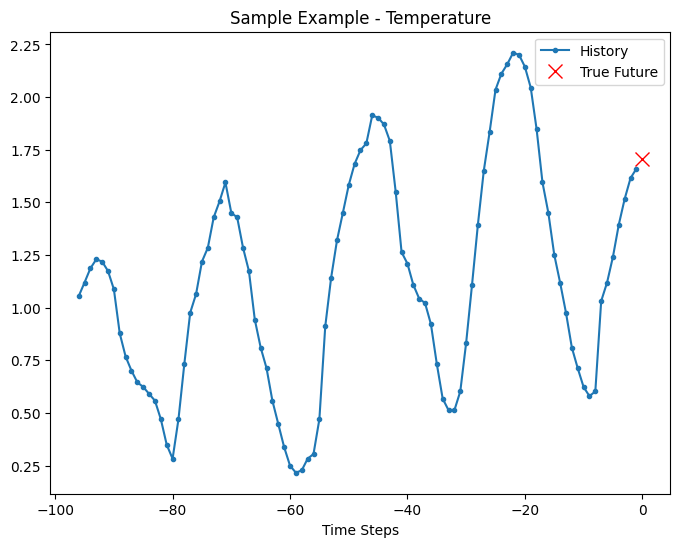

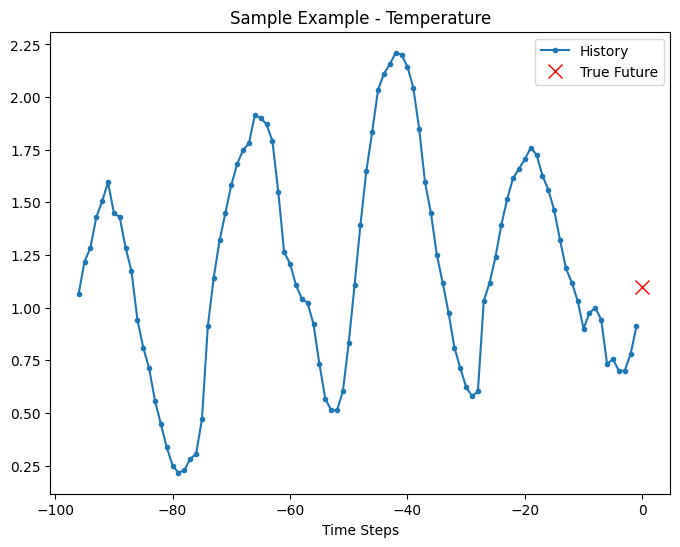

In [38]:
# Function to create data for univariate forecasting
def univariate_data(dataset, start_idx, end_idx, history_size, target_size):
    data = []
    labels = []
    start_idx = start_idx + history_size
    if end_idx is None:
        end_idx = len(dataset) - target_size
    for i in range(start_idx, end_idx):
        idxs = range(i - history_size, i)
        data.append(dataset[idxs])
        labels.append(dataset[i + target_size])
    return np.array(data), np.array(labels)

uni_data_history = 96 # Last 20 values
uni_data_future = 0    # Future data

x_train_uni_temp, y_train_uni_temp = univariate_data(uni_data_temp, 0, train_split, uni_data_history, uni_data_future)
x_val_uni_temp, y_val_uni_temp = univariate_data(uni_data_temp, train_split, None, uni_data_history, uni_data_future)

print(x_train_uni_temp.shape)  # (151495, 20, 4)
print(y_train_uni_temp.shape)  # (151495, 4)
print(x_val_uni_temp.shape)    # (37859, 20, 4)
print(y_val_uni_temp.shape)    # (37859, 4)

# Function to create time steps
def create_time_steps(length):
    return list(range(-length, 0))

# Function to plot time series data
def plot_time_series(plot_data, delta, title):
    labels = ["History", "True Future", "Model Predicted"]
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i == 0:
            plt.plot(time_steps, plot_data[i][:, 0], marker[i], label=labels[i])  # Plot only the first feature for simplicity
        else:
            future = time_steps[-1] + 1
            plt.plot([future], plot_data[i], marker[i], markersize=10, label=labels[i])  # Plot single future point
    plt.legend()
    plt.xlabel('Time Steps')
    plt.show()

# Example of plotting the first sample
plot_time_series([x_train_uni_temp[0], y_train_uni_temp[0][0]], 0, 'Sample Example - Temperature')

# Example of plotting another sample
i = 20
plot_time_series([x_train_uni_temp[i], y_train_uni_temp[i][0]], 0, 'Sample Example - Temperature')



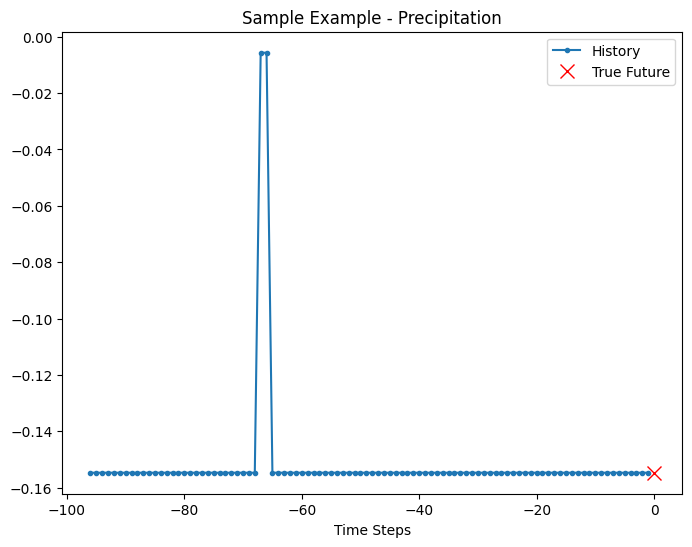

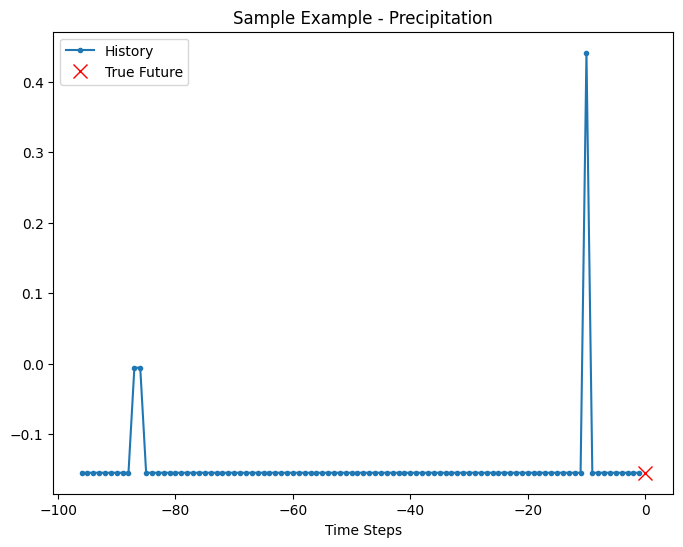

In [39]:
# # Prepare the univar# Define the columns for precipitation forecasts
# precipitation_cols =['poprecipitation_forecast+{}h'.format(i) for i in range(96)]
# # Extract precipitation forecast features
# precipitation_features = dfP

# scaler_precip = StandardScaler()
# uni_data_precip = scaler_precip.fit_transform(precipitation_features.values)

# # Assuming train_split is already defined appropriately
# tf.random.set_seed(13)


# # Standardize data
# uni_data_precip_mean = uni_data_precip[:train_split].mean(axis=0)
# uni_data_precip_std = uni_data_precip[:train_split].std(axis=0)
# uni_data_precip = (uni_data_precip - uni_data_precip_mean) / uni_data_precip_std

x_train_uni_precip, y_train_uni_precip= univariate_data(uni_data_precip[:train_split], 0, train_split, uni_data_history, uni_data_future)
x_val_uni_precip, y_val_uni_precip= univariate_data(uni_data_precip[train_split:], 0, None, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, 0, train_split, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, train_split, None, uni_data_history, uni_data_future)
x_train_uni_precip.shape, y_train_uni_precip.shape
x_val_uni_precip.shape, y_val_uni_precip.shape

plot_time_series([x_train_uni_precip[0], y_train_uni_precip[0][0]], 0, 'Sample Example - Precipitation')
i = 20
plot_time_series([x_train_uni_precip[i], y_train_uni_precip[i][0]], 0, 'Sample Example - Precipitation')


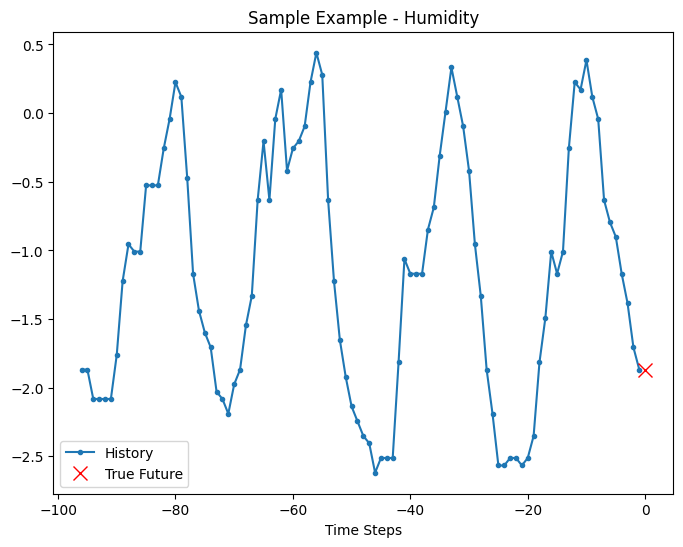

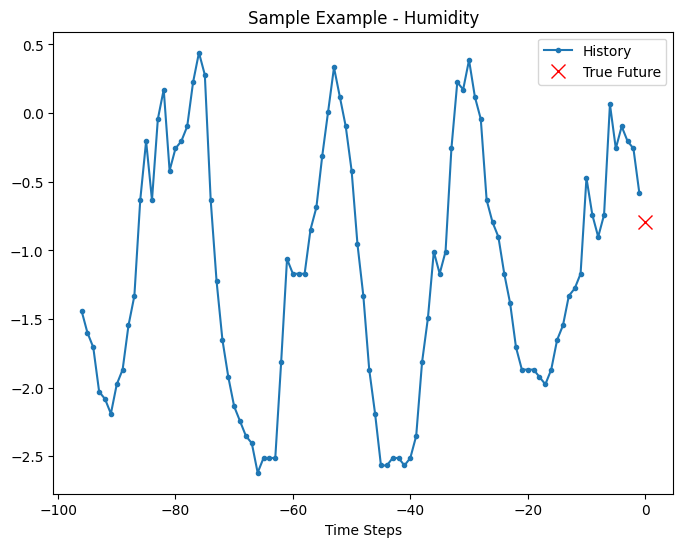

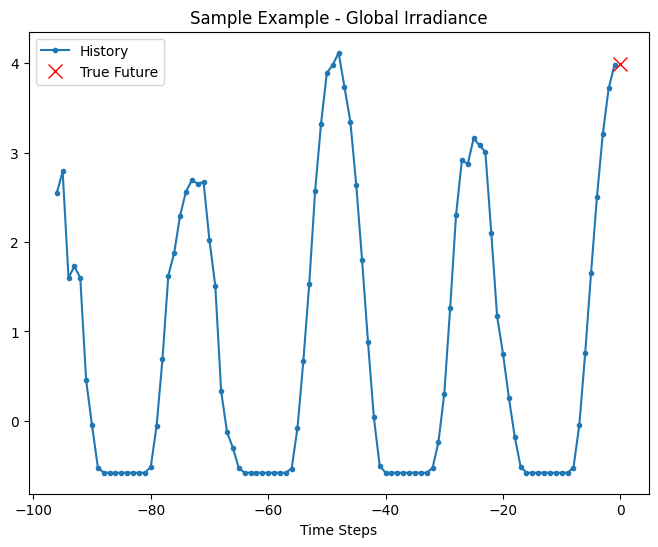

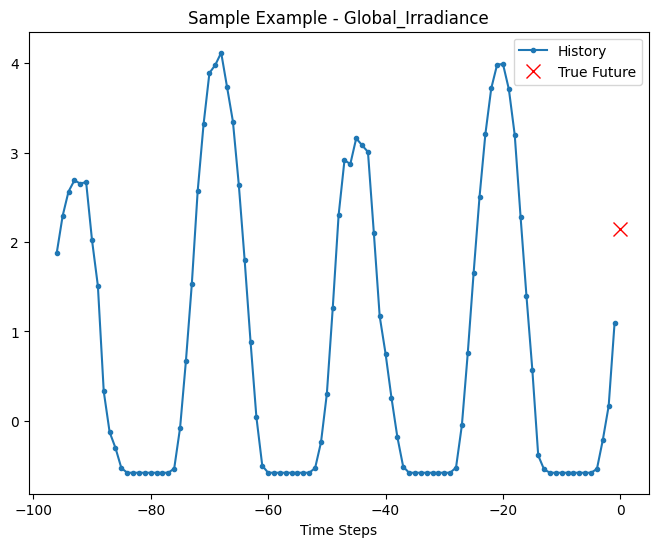

In [40]:
x_train_uni_humid, y_train_uni_humid= univariate_data(uni_data_humid[:train_split], 0, train_split, uni_data_history, uni_data_future)
x_val_uni_humid, y_val_uni_humid= univariate_data(uni_data_humid[train_split:], 0, None, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, 0, train_split, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, train_split, None, uni_data_history, uni_data_future)
x_train_uni_humid.shape, y_train_uni_humid.shape
x_val_uni_humid.shape, y_val_uni_humid.shape

plot_time_series([x_train_uni_humid[0], y_train_uni_humid[0][0]], 0, 'Sample Example - Humidity')
i = 20
plot_time_series([x_train_uni_humid[i], y_train_uni_humid[i][0]], 0, 'Sample Example - Humidity')

x_train_uni_Gr, y_train_uni_Gr= univariate_data(uni_data_Gr[:train_split], 0, train_split, uni_data_history, uni_data_future)
x_val_uni_Gr, y_val_uni_Gr= univariate_data(uni_data_Gr[train_split:], 0, None, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, 0, train_split, uni_data_history, uni_data_future)
#  = univariate_data(uni_data_precip, train_split, None, uni_data_history, uni_data_future)
x_train_uni_Gr.shape, y_train_uni_Gr.shape
x_val_uni_Gr.shape, y_val_uni_Gr.shape

plot_time_series([x_train_uni_Gr[0], y_train_uni_Gr[0][0]], 0, 'Sample Example - Global Irradiance')
i = 20
plot_time_series([x_train_uni_Gr[i], y_train_uni_Gr[i][0]], 0, 'Sample Example - Global_Irradiance')

In [48]:
# Prepare tensorflow dataset for univariate temperature model
batch_size = 256
buffer_size = 10000

train_uni_temp = tf.data.Dataset.from_tensor_slices((x_train_uni_temp, y_train_uni_temp))
train_uni_temp = train_uni_temp.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_temp = tf.data.Dataset.from_tensor_slices((x_val_uni_temp, y_val_uni_temp))
val_uni_temp = val_uni_temp.cache().shuffle(buffer_size).batch(batch_size).repeat()

# # Prepare tensorflow dataset for univariate precipitation model
train_uni_precip = tf.data.Dataset.from_tensor_slices((x_train_uni_precip, y_train_uni_precip))
train_uni_precip = train_uni_precip.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_precip = tf.data.Dataset.from_tensor_slices((x_val_uni_precip, y_val_uni_precip))
val_uni_precip = val_uni_precip.cache().shuffle(buffer_size).batch(batch_size).repeat()

# # Prepare tensorflow dataset for univariate precipitation model
train_uni_humid = tf.data.Dataset.from_tensor_slices((x_train_uni_humid, y_train_uni_humid))
train_uni_humid = train_uni_humid.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_humid = tf.data.Dataset.from_tensor_slices((x_val_uni_humid, y_val_uni_humid))
val_uni_humid = val_uni_humid.cache().shuffle(buffer_size).batch(batch_size).repeat()

# # Prepare tensorflow dataset for univariate precipitation model
train_uni_Gr = tf.data.Dataset.from_tensor_slices((x_train_uni_Gr, y_train_uni_Gr))
train_uni_Gr = train_uni_Gr.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni_Gr = tf.data.Dataset.from_tensor_slices((x_val_uni_Gr, y_val_uni_Gr))
val_uni_Gr = val_uni_Gr.cache().shuffle(buffer_size).batch(batch_size).repeat()


In [49]:
# # Define LSTM model for temperature
# lstm_model_temp = tf.keras.models.Sequential([
#     tf.keras.layers.LSTM(8, input_shape=x_train_uni_temp.shape[-2:]),
#     tf.keras.layers.Dense(1)
# ])

# # Compile the model with optimizer and loss function
# lstm_model_temp.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3, weight_decay=1e-5),
#                         loss='mae')
lstm_model_temp = tf.keras.models.Sequential()
lstm_model_temp.add(tf.keras.layers.LSTM(16, return_sequences=True,input_shape = x_train_uni_temp.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=False))
# single_step_model.add(tf.keras.layers.Dense(4, activation="relu"))
lstm_model_temp.add(tf.keras.layers.Dense(1))
lstm_model_temp.compile(optimizer = tf.keras.optimizers.Adam(weight_decay=1e-5), loss = 'mae')
lstm_model_temp.summary()
# # Print model summary
# lstm_model_temp.summary()

# Train LSTM model for temperature
EVALUATION_INTERVAL = 200
EPOCHS = 20

temp_history = lstm_model_temp.fit(train_uni_temp, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                   validation_data=val_uni_temp, validation_steps=50)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 96, 16)         │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 96, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.2679 - val_loss: 0.2029
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.1408 - val_loss: 0.1913
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - loss: 0.1279 - val_loss: 0.1807
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.1204 - val_loss: 0.1819
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.1152 - val_loss: 0.1841
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.1111 - val_loss: 0.1861
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 0.1078 - val_loss: 0.1880
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.1054 - val_loss: 0.1900
Epoch 9/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 0.1030 - val_loss: 0.1919
Epoch 10/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 0.1015 - val_loss: 0.1915
Epoch 11/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.1003 - val_loss: 0.1924
Epoch 12/20
200/200 ━━━━━━━━━━━━━━━━━━━━

In [43]:
mae_lstm_single_temp = lstm_model_temp.evaluate(val_uni_temp, steps=100)
print(f"Mean Absolute Error (MAE): {mae_lstm_single_temp}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2487
Mean Absolute Error (MAE): 0.24875880777835846


In [44]:
# Define LSTM model for precipitation
lstm_model_precip = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(16, input_shape=x_train_uni_precip.shape[-2:]),
    tf.keras.layers.Dense(1)
])
lstm_model_precip.compile(optimizer='adam', loss='mae')
lstm_model_precip.summary()

# Train LSTM model for precipitation
precip_history = lstm_model_precip.fit(train_uni_precip, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                       validation_data=val_uni_precip, validation_steps=50)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 16)             │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,249 (28.32 KB)

 Trainable params: 7,249 (28.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2864 - val_loss: 0.2833
Epoch 2/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2503 - val_loss: 0.2803
Epoch 3/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2428 - val_loss: 0.2717
Epoch 4/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2394 - val_loss: 0.2777
Epoch 5/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2414 - val_loss: 0.2758
Epoch 6/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2424 - val_loss: 0.2718
Epoch 7/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2425 - val_loss: 0.2741
Epoch 8/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2390 - val_loss: 0.2701
Epoch 9/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2358 - val_loss: 0.2702
Epoch 10/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.2392 - val_loss: 0.2778
Epoch 11/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2417 - val_loss: 0.2699
Epoch 12/25
200/200 ━━━━━━━━━━━━━━━━━━━━ 

In [45]:
mae_lstm_single = lstm_model_precip.evaluate(val_uni_precip, steps=100)

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2677


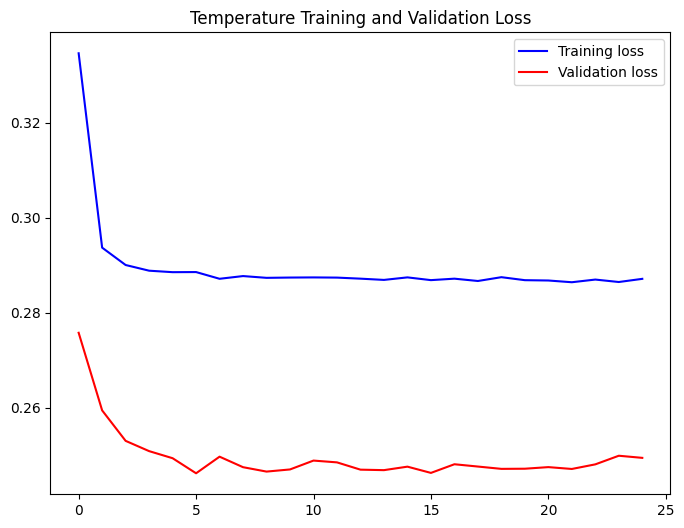

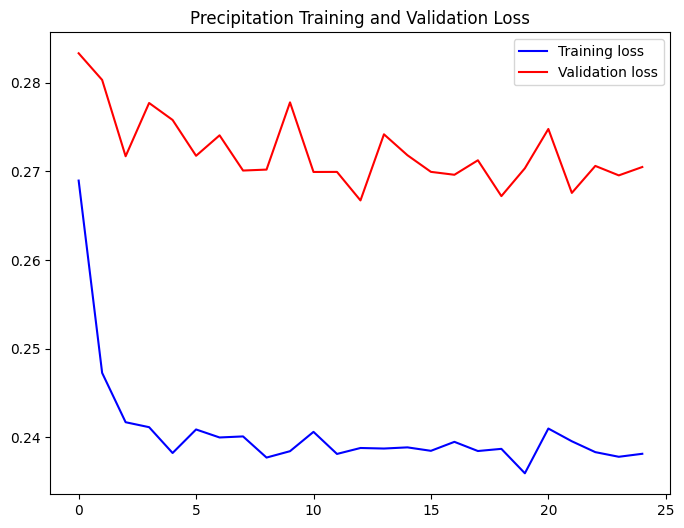

In [46]:
# Plotting function for training history
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

plot_train_history(temp_history, 'Temperature Training and Validation Loss')
plot_train_history(precip_history, 'Precipitation Training and Validation Loss')


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming the variables like train_split, buffer_size, batch_size, create_time_steps are defined appropriately

# Multivariate model using selected features
features = [
    'temperature_mean', 'temperature_std', 'temperature_min', 'temperature_max',
    'humidity_mean', 'humidity_std', 'humidity_min', 'humidity_max',
    'poprecipitation_mean', 'poprecipitation_std', 'poprecipitation_min', 'poprecipitation_max'
]

# Filter the DataFrame to include only the selected features
multi_features = df[features].values

# Normalize the features
multi_data_mean = multi_features[:train_split].mean(axis=0)
multi_data_std = multi_features[:train_split].std(axis=0)
multi_features = (multi_features - multi_data_mean) / multi_data_std

# Function to create multivariate data
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    end_index = end_index if end_index is not None else len(dataset) - target_size
    start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])

    return np.array(data), np.array(labels)

history_size = 1440
target_size = 144
STEP = 6

# Create training and validation data
x_train_multi, y_train_multi = multivariate_data(multi_features, multi_features[:, 0], 0, train_split, history_size, target_size, STEP, single_step=True)
x_val_multi, y_val_multi = multivariate_data(multi_features, multi_features[:, 0], train_split, None, history_size, target_size, STEP, single_step=True)

# Create TensorFlow datasets
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

# Multivariate LSTM model
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),  # Additional dense layer if needed
    tf.keras.layers.Dense(target_size)  # Output layer predicting 144 time steps into the future
])

multi_step_model.compile(optimizer='adam', loss='mae')

# Verify model output shape
for x, y in val_data_multi.take(1):
    print("Model Output Shape:", multi_step_model.predict(x).shape)

# Define training parameters
EVALUATION_INTERVAL = 200
EPOCHS = 10

# Train the model
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi, validation_steps=50)

# Plot training history
plot_train_history(multi_step_history, 'Multi-Step Training and Validation Loss')

# Plot some predictions
for x, y in val_data_multi.take(5):
    plot_time_series([x[0][:, 0].numpy(), y[0].numpy(), multi_step_model.predict(x)], 0, 'LSTM Multi-Step')


In [ ]:
mae_lstm_single = multi_step_model.evaluate(val_uni_multi, steps=100)

Moving Window Average


1.   Given last 20 values of observations(temp) , predict next observation
2.   MWA: predict== AVG(last 20 values)




In [ ]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 20   ## last 50 values
uni_data_future = 0     ## future data

x_train_uni , y_train_uni = univariate_data(uni_data , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(uni_data , train_split , None ,uni_data_history , uni_data_future)

In [ ]:
x_train_uni

In [ ]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

In [ ]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])


In [ ]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt
## function to plot time series data



plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

In [ ]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [ ]:
### Moving window average

def MWA(history):
  return np.mean(history)




In [ ]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting


*   Only single feature as temperature(historical data)
*   Task:  Given last 20 observations(history) , predict next temperature value 



In [ ]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

In [ ]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8 , input_shape = x_train_uni.shape[-2:]), 
                                         tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps ,
               validation_data = val_uni, validation_steps = 50)




In [ ]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

Multivariate  and Single step Forecasting


*   Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step




In [ ]:
## features 

# features_6 = ['temperature', 'humidity', 'pressure', 'global_irradiance', 'direct_irradiance', 'diffuse_irradiance']
features14 = [
    'temperature', 'humidity', 'pressure',
    'cloud_cover', 'wind_speed', 'wind_direction', 'poprecipitation'
]
features = df[features14]
features.head()



In [ ]:
features.isnull().sum()
features=features.fillna(features.mean())

In [ ]:
features.plot(subplots=True)

In [ ]:
# ### standardize data
dataset = features.values
# dataset = np.array(features)
data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std



In [ ]:
# # ### create mutlivariate data

# def multivariate_data(dataset, target, start_idx, end_idx, history_size, target_size, step, single_step=False):
#     data, labels = [], []
#     start_idx += history_size
#     if end_idx is None:
#         end_idx = len(dataset) - target_size
#     for i in range(start_idx, end_idx):
#         indices = range(i-history_size, i, step)
#         data.append(dataset[indices])
#         if single_step:
#             labels.append(target[i+target_size])
#         else:
#             labels.append(target[i:i+target_size])
#     return np.array(data), np.array(labels)
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    # Adjust end_index to avoid out-of-bounds error
    end_index = end_index if end_index is not None else len(dataset) - target_size
    
    # Adjust start_index to accommodate history_size
    start_index = start_index + history_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    
    return np.array(data), np.array(labels)


In [ ]:
# ### generate multivariate data
from sklearn.preprocessing import StandardScaler
# history = 720
# future_target = 72
# STEP = 6

# x_train_ss, y_train_ss = multivariate_data(dataset, dataset[:, 1], 0, train_split, history,
#                                            future_target, STEP, single_step=True)


# x_val_ss , y_val_ss = multivariate_data(dataset , dataset[:,1] , train_split , None , history,
#                                         future_target, STEP, single_step = True)


# print(x_train_ss.shape , y_train_ss.shape)
# Define your parameters
# Define your parameters
history = 720
future_target = 72
STEP = 6
train_split = int(len(dataset) * 0.7)
# scaler = StandardScaler()
# scaler.fit(dataset[:train_split])

# # Transform the entire dataset
# dataset = scaler.transform(dataset)
# Get training data
x_train_ss, y_train_ss = multivariate_data(dataset, dataset[:, 1], 0, train_split, history, future_target, STEP, single_step=True)

# Get validation data
x_val_ss, y_val_ss = multivariate_data(dataset, dataset[:, 1], train_split, None, history, future_target, STEP, single_step=True)

# Check shapes
print(x_train_ss.shape, y_train_ss.shape)
print(x_val_ss.shape, y_val_ss.shape)



In [ ]:
x_train_ss

In [ ]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)



In [ ]:
### Modelling using LSTM
from keras.callbacks import EarlyStopping
callbacks = EarlyStopping(
    patience = 10 , 
    restore_best_weights = True , 
    monitor = 'val_loss'
)
single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(16, return_sequences=True,input_shape = x_train_ss.shape[-2:]))
# single_step_model.add(tf.keras.layers.LSTM(16,return_sequences=False))
# single_step_model.add(tf.keras.layers.Dense(4, activation="relu"))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss = 'mae')
single_step_model.summary()


single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS ,
                                                  steps_per_epoch =steps,verbose=1, validation_data = val_ss,
                                                  validation_steps = 50)


In [ ]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

In [ ]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting
-> Generate multiple future values of temperature

In [ ]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

In [ ]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [ ]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [ ]:
# multi_step_model = tf.keras.models.Sequential()
# multi_step_model.add(tf.keras.layers.LSTM(16,
#                                           return_sequences=True,
#                                           input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.LSTM(32,return_sequences=False, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(4))
# multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

# multi_step_model.compile(optimizer=tf.keras.optimizers.SGD(clipvalue=1.0,weight_decay=1e-6), loss='mae')
# multi_step_model.summary()
# multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
#                                           steps_per_epoch=steps,
#                                           validation_data=val_data_multi,
#                                           validation_steps=50,callbacks = [callbacks])



# Define the model
multi_step_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=x_train_multi.shape[-2:]),
    # tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    tf.keras.layers.LSTM(16, return_sequences=False, activation='relu'),
    # tf.keras.layers.Dropout(0.2),  # Dropout layer for regularization
    # tf.keras.layers.LSTM(2, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),  # Additional dense layer
    tf.keras.layers.Dense(72)  # 72 outputs for future predictions
])

# Compile the model
multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(clipvalue=1.0,weight_decay=1e-6), loss='mae')

# Print the model summary
multi_step_model.summary()

# Define callbacks for early stopping and learning rate scheduling
# 

# Fit the model
enhanced_history = multi_step_model.fit(train_data_multi, 
                                      epochs=EPOCHS,
                                      steps_per_epoch=steps,
                                      validation_data=val_data_multi,
                                      validation_steps=50
                                    )

In [ ]:
plot_loss(enhanced_history, 'Multi-Step Training and validation loss')


In [ ]:
for x, y in val_data_multi.take(5):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [ ]:
mae_lstm_single = single_step_model.evaluate(val_ss, steps=100)
mae_lstm_multi=multi_step_model.evaluate(val_data_multi, steps=100)

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_multi_step_model_measure+precip.h5')
loaded_model2 = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_single_step_model_measure+precip.h5')

# Optionally, you can verify the model by making predictions
for x, y in val_data_multi.take(5):

    predictions = loaded_model.predict(x)
    multi_step_plot(x[0], y[0], loaded_model.predict(x)[0])


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanAbsoluteError
import numpy as np
import matplotlib.pyplot as plt

# Define a dictionary with custom objects if needed
custom_objects = {'mae': MeanAbsoluteError()}

# Load the models
loaded_model = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_multi_step_model_measure+precip.h5', custom_objects=custom_objects)
loaded_model2 = load_model('/Users/faymajidelhassan/Downloads/Master project /CODE/EDA/Saved_models/Lstm_single_step_model_measure+precip.h5', custom_objects=custom_objects)

print("Models loaded successfully")

# Define the multi-step plot function
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = list(range(-len(history), 0))
    num_out = list(range(len(true_future)))

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(num_out, np.array(true_future), 'bo-', label='True Future')  # Change 'bo' to 'bo-' to plot line with markers
    plt.plot(num_out, np.array(prediction), 'ro-', label='Predicted Future')  # Change 'ro' to 'ro-' to plot line with markers

    plt.legend(loc='upper left')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Multi-Step Forecasting')
    plt.grid(True)
    plt.show()

# Use the loaded model to make predictions and plot them
for x, y in val_data_multi.take(5):
    prediction = loaded_model.predict(x)[0]
    multi_step_plot(x[0], y[0], prediction)


In [ ]:
mae_lstm_multi=loaded_model.evaluate(val_data_multi, steps=100)

In [ ]:
for x, y in val_ss.take(5):
    prediction = transformer_model.predict(x)
    plot = plot_time_series([x[0].numpy(), y[0].numpy(), prediction[0]], 'Transformer UNIVARIATE')
    plot.show()
